In [15]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [16]:
# Step 0: Import necessary libraries
# We'll need pandas for data manipulation, sklearn for data and splitting,
# and of course xgboost itself.
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Optional: For advanced model interpretation (Step 5)
try:
    import shap
except ImportError:
    print("SHAP library not found. Please install it for Step 5: pip install shap")
    shap = None

print(f"XGBoost version: {xgb.__version__}")

XGBoost version: 2.1.4


In [17]:
# --- Step 1: Data Preparation ---
# Instead of a housing dataset, we'll create a synthetic fisheries dataset.
# Our goal is to predict fish abundance (Catch Per Unit Effort - CPUE)
# based on common environmental variables from a trawl survey.

def create_fisheries_data(n_samples=2000):
    """Generates a synthetic dataset for predicting fish CPUE."""
    np.random.seed(42)
    
    # Environmental Features
    bottom_temp = np.random.uniform(2, 15, n_samples)
    salinity = np.random.uniform(28, 35, n_samples)
    depth = np.random.uniform(20, 200, n_samples)
    day_of_year = np.random.randint(60, 150, n_samples) # March to May
    
    # Create a non-linear relationship between temperature and CPUE (dome-shaped)
    # Fish have an optimal temperature range.
    temp_effect = -0.1 * (bottom_temp - 8)**2
    
    # Other linear effects
    salinity_effect = 0.05 * salinity
    depth_effect = -0.01 * depth
    
    # Add some noise
    noise = np.random.normal(0, 0.5, n_samples)
    
    # Calculate a base CPUE and ensure it's non-negative
    base_cpue = 10 + temp_effect + salinity_effect + depth_effect + noise
    base_cpue[base_cpue < 0] = 0
    
    # It's common practice to log-transform CPUE to handle zeros and skewness
    y = np.log1p(base_cpue)
    
    X = pd.DataFrame({
        'BottomTemp': bottom_temp,
        'Salinity': salinity,
        'Depth': depth,
        'DayOfYear': day_of_year
    })
    
    return X, y

print("\n--- Step 1: Creating and Preparing Fisheries Data ---")
X_df, y = create_fisheries_data()
feature_names = X_df.columns.tolist()

# Split data into training and validation sets. This is crucial for using
# early stopping later on.
X_train, X_val, y_train, y_val = train_test_split(X_df, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print("Example features:\n", X_train.head())


--- Step 1: Creating and Preparing Fisheries Data ---
Training data shape: (1600, 4)
Validation data shape: (400, 4)
Example features:
      BottomTemp   Salinity       Depth  DayOfYear
968    9.363260  34.629635  192.284270        130
240   14.225962  33.562048  141.619322        131
819    6.357564  30.499205   55.859543        133
692    8.598935  28.069467   81.936491         74
420   12.290528  29.120175   37.716354        111


In [18]:
# --- Step 2: Model Initialization (The `mgcv::gam` Analogy) ---
# Here, we create an instance of the XGBoost model. This is like setting up
# your gam() call with its parameters before you actually fit it to data.
# We'll use XGBRegressor to predict the continuous log(CPUE+1) value.

print("\n--- Step 2: Initializing the XGBoost Model ---")

# Let's define the core parameters.
# mgcv::gam(log_cpue ~ s(BottomTemp, k=10) + s(Depth, k=10), sp=c(0.1, 0.5), ...)
# is analogous to...
xgb_reg = xgb.XGBRegressor(
    # --- Boosting Parameters (How the model learns) ---
    n_estimators=1000,         # Analogous to the "richness" of the model. Number of trees to build.
                               # We set this high and use early stopping to find the optimal number.
    learning_rate=0.05,        # Analogous to a shrinkage parameter. Lower values make the model more robust.

    # --- Tree Complexity Parameters (Analogous to `k` and `sp`) ---
    max_depth=5,               # Analogous to `k` in s(x, k=...). Controls max interaction depth.
    min_child_weight=1,        # A form of regularization. Prevents learning highly specific patterns.
    gamma=0.1,                 # Analogous to `sp`. A value > 0 penalizes splits, making the model more conservative.
    subsample=0.8,             # Use 80% of data for building each tree. Adds randomness to fight overfitting.
    colsample_bytree=0.8,      # Use 80% of features for building each tree. Also for overfitting.

    # --- Regularization Parameters (Directly analogous to `sp`) ---
    reg_alpha=0.005,           # L1 regularization on leaf weights.
    reg_lambda=1,              # L2 regularization on leaf weights.

    # --- Technical Parameters ---
    objective='reg:squarederror', # The loss function to optimize.
    n_jobs=-1,                 # Use all available CPU cores.
    random_state=42,           # For reproducibility.
    eval_metric='rmse'         # Metric to monitor during training.
)

print("Model initialized with parameters:")
print(xgb_reg.get_params())


--- Step 2: Initializing the XGBoost Model ---
Model initialized with parameters:
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'rmse', 'feature_types': None, 'gamma': 0.1, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.05, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 1000, 'n_jobs': -1, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': 0.005, 'reg_lambda': 1, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [19]:
print("\n--- Step 3: Training the Model with Early Stopping ---")

# The `eval_set` is used for early stopping.
# XGBoost will calculate the RMSE on the validation set after each tree is added.
# If the RMSE doesn't improve for `early_stopping_rounds`, training stops.
xgb_reg.fit(X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False) # Set verbose=True to see the training progress

print(f"Model training complete.")
# FIX: Access the evaluation results dictionary which is always available.
# The .best_iteration and .best_score attributes are only set if early stopping
# is actually triggered. This is a more robust way to get the results.
results = xgb_reg.evals_result()
best_iteration = np.argmin(results['validation_0']['rmse'])
best_score = results['validation_0']['rmse'][best_iteration]

print(f"Best iteration found: {best_iteration}")
print(f"Best validation RMSE: {best_score:.4f}")


--- Step 3: Training the Model with Early Stopping ---
Model training complete.
Best iteration found: 992
Best validation RMSE: 0.0582


In [20]:
# --- Step 4: Making Predictions ---
# This is straightforward, just like `predict.gam`.
# The model automatically uses the optimal number of trees found during early stopping.

print("\n--- Step 4: Making Predictions ---")
predictions = xgb_reg.predict(X_val)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_val, predictions))
print(f"Final RMSE on validation data: {rmse:.4f}")


--- Step 4: Making Predictions ---
Final RMSE on validation data: 0.0582



--- Step 5: Interpreting the Model ---
Plotting feature importance...


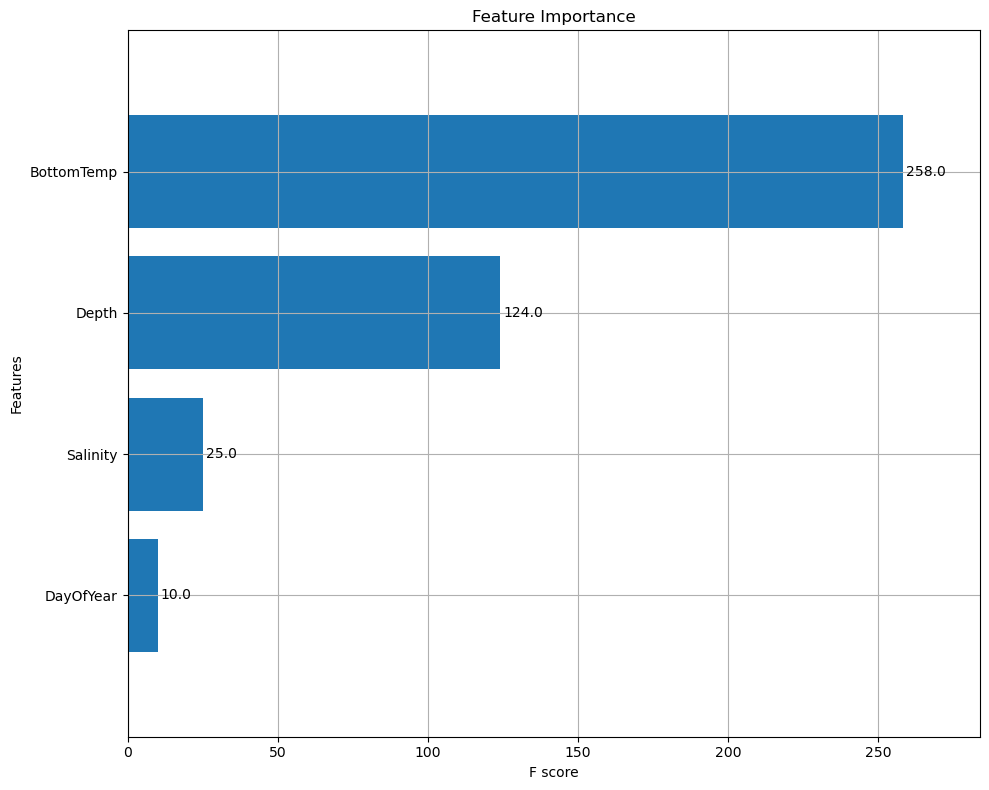


Calculating and plotting SHAP values...


/tmp/ipykernel_159/1607357047.py:30: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_val, plot_type="dot", show=False)


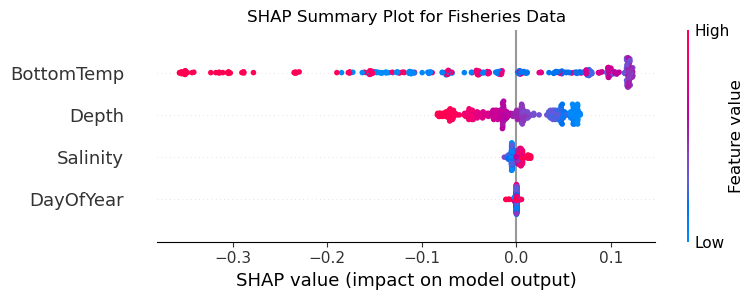

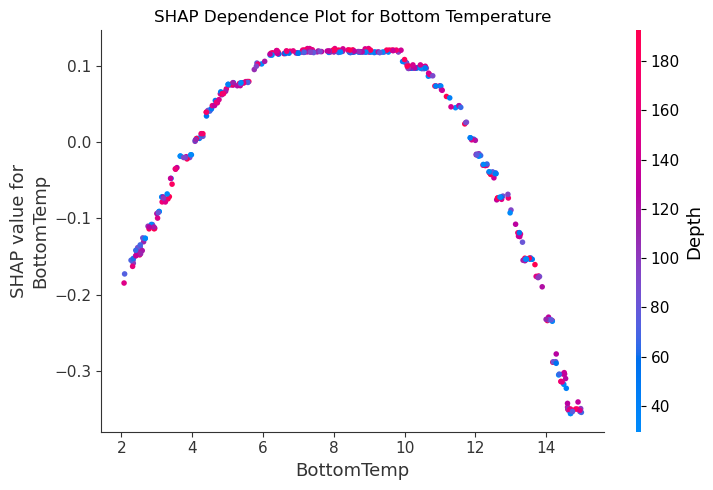

In [21]:


# --- Step 5: Model Interpretation (The `mgcv::plot.gam` Analogy) ---
# We can't plot smooths, but we can get powerful insights.

print("\n--- Step 5: Interpreting the Model ---")

# 5a. Feature Importance
# This is like looking at the p-values in `summary.gam`. It tells you which
# environmental variables the model used most to predict CPUE.
print("Plotting feature importance...")
fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(xgb_reg, ax=ax, max_num_features=10, height=0.8, title="Feature Importance")
plt.tight_layout()
plt.show()


# 5b. SHAP Values (Advanced but powerful!)
# This is the modern equivalent of partial dependence plots or `plot.gam`.
# It explains *how* each feature impacts the prediction for every single survey point.
if shap:
    print("\nCalculating and plotting SHAP values...")
    # Create a SHAP explainer object
    explainer = shap.TreeExplainer(xgb_reg)

    # Calculate SHAP values for the validation set
    shap_values = explainer.shap_values(X_val)

    # Summary plot: Shows the distribution of impacts for each feature.
    # Red means high feature value, blue means low.
    # Points to the right increase the prediction, points to the left decrease it.
    shap.summary_plot(shap_values, X_val, plot_type="dot", show=False)
    plt.title("SHAP Summary Plot for Fisheries Data")
    plt.tight_layout()
    plt.show()

    # Dependence plot: Shows the effect of a single feature across the whole dataset.
    # This is the closest thing to a partial effect plot from a GAM.
    # It shows how the predicted log(CPUE+1) changes as 'BottomTemp' changes.
    # We can clearly see the dome-shaped relationship we created!
    shap.dependence_plot("BottomTemp", shap_values, X_val, show=False)
    plt.title("SHAP Dependence Plot for Bottom Temperature")
    plt.tight_layout()
    plt.show()
else:
    print("\nSkipping SHAP plots as the 'shap' library is not installed.")

In [23]:
# --- Step 6: Create a Spatial Grid for Prediction ---
print("\n--- Step 6: Making Predictions on a Spatial Grid ---")

# Create a grid of two variables we want to map: Depth and BottomTemp
grid_depth = np.linspace(X_df['Depth'].min(), X_df['Depth'].max(), 50)
grid_temp = np.linspace(X_df['BottomTemp'].min(), X_df['BottomTemp'].max(), 50)
xx, yy = np.meshgrid(grid_depth, grid_temp)

# Create a DataFrame for the grid. The model needs all the original features.
# We'll hold the other features constant at their average value.
grid_df = pd.DataFrame({
    'Depth': xx.ravel(),
    'BottomTemp': yy.ravel(),
    'Salinity': X_train['Salinity'].mean(),      # Hold constant
    'DayOfYear': X_train['DayOfYear'].mean()     # Hold constant (predicting for an "average" day)
})

# FIX: Ensure the column order of the prediction grid matches the training data
grid_df = grid_df[X_train.columns]

print(f"Created a prediction grid with {grid_df.shape[0]} points.")

# --- Step 7: Predict CPUE on the Grid ---
# Use the trained model to predict log(CPUE+1)
grid_predictions_log = xgb_reg.predict(grid_df)

# Back-transform the predictions to the original CPUE scale
grid_predictions_cpue = np.expm1(grid_predictions_log)

# Add predictions to our grid DataFrame for plotting
grid_df['Predicted_CPUE'] = grid_predictions_cpue


--- Step 6: Making Predictions on a Spatial Grid ---
Created a prediction grid with 2500 points.



--- Step 8: Visualizing the Spatial Predictions ---


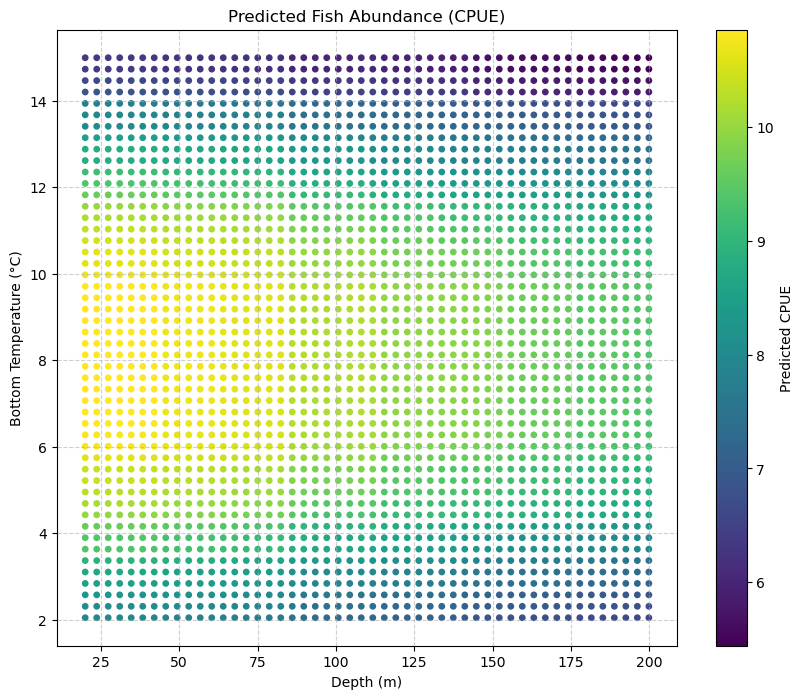

In [24]:
# --- Step 8: Create a Spatial Plot of Predictions ---
print("\n--- Step 8: Visualizing the Spatial Predictions ---")

plt.figure(figsize=(10, 8))
# Use a scatter plot where the color of each point is the predicted CPUE
scatter = plt.scatter(
    grid_df['Depth'], 
    grid_df['BottomTemp'], 
    c=grid_df['Predicted_CPUE'], 
    cmap='viridis', # A color-blind friendly colormap
    s=15 # size of points
)

# Add a color bar to show the CPUE scale
cbar = plt.colorbar(scatter)
cbar.set_label('Predicted CPUE')

plt.xlabel('Depth (m)')
plt.ylabel('Bottom Temperature (°C)')
plt.title('Predicted Fish Abundance (CPUE)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


--- Step 8: Visualizing the Spatial Predictions ---


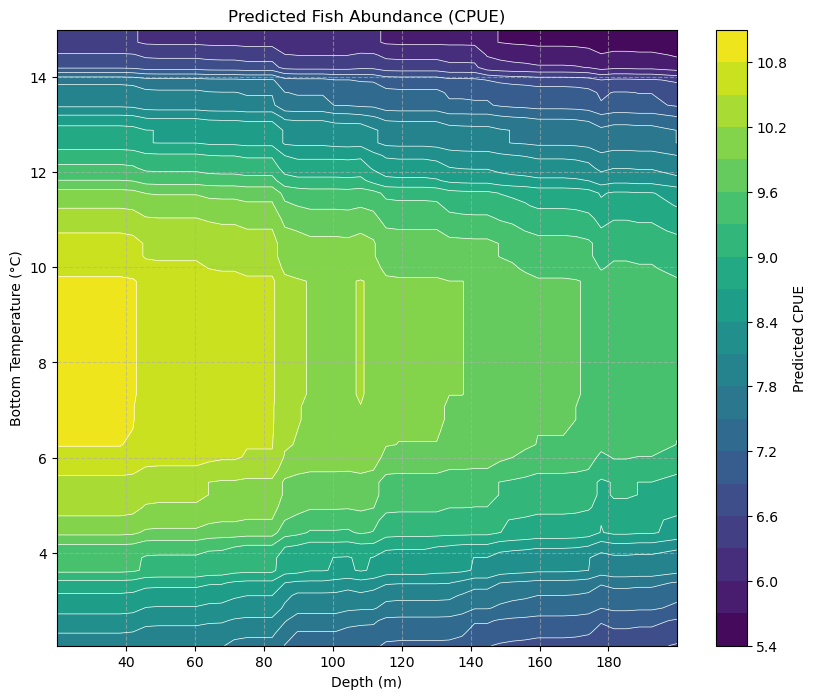

In [25]:
# --- Step 8: Create a Spatial Plot of Predictions ---
print("\n--- Step 8: Visualizing the Spatial Predictions ---")

# Reshape the predictions to match the grid shape for contour plotting
Z = grid_df['Predicted_CPUE'].values.reshape(xx.shape)

plt.figure(figsize=(10, 8))
# Use a filled contour plot for a smooth surface
contour = plt.contourf(xx, yy, Z, cmap='viridis', levels=20)

# Add contour lines for better definition
plt.contour(xx, yy, Z, colors='white', linewidths=0.5, levels=20)

# Add a color bar to show the CPUE scale
cbar = plt.colorbar(contour)
cbar.set_label('Predicted CPUE')

plt.xlabel('Depth (m)')
plt.ylabel('Bottom Temperature (°C)')
plt.title('Predicted Fish Abundance (CPUE)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


--- Step 9: Creating a Map with Cartopy ---


/srv/conda/envs/notebook/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/srv/conda/envs/notebook/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/srv/conda/envs/notebook/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


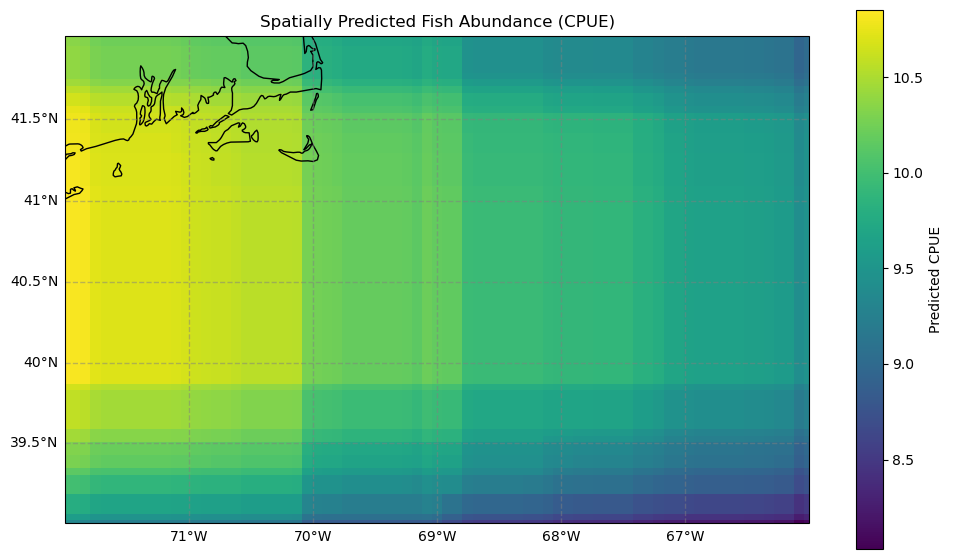

In [26]:
# --- Step 9: Create a Publication-Quality Map with Cartopy ---

# You may need to install these libraries first:
# pip install geopandas cartopy

import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

print("\n--- Step 9: Creating a Map with Cartopy ---")

# 1. Create a new prediction grid with Latitude and Longitude
# Let's simulate a survey area off the coast of New England
n_grid = 75  # Increase grid resolution for a nicer map
grid_lon = np.linspace(-72, -66, n_grid) # Longitude range
grid_lat = np.linspace(39, 42, n_grid)   # Latitude range
lon_xx, lat_yy = np.meshgrid(grid_lon, grid_lat)

# Create a DataFrame for the new grid.
# We need to provide plausible environmental data for this new grid.
# For a real project, you'd get this from a raster/gridded data source (like GLORYS).
# For this demo, we'll just simulate it based on the training data ranges.
map_grid_df = pd.DataFrame({
    'Longitude': lon_xx.ravel(),
    'Latitude': lat_yy.ravel(),
    'BottomTemp': np.interp(lat_yy.ravel(), [grid_lat.min(), grid_lat.max()], [12, 5]), # Simple temp gradient
    'Depth': np.interp(lon_xx.ravel(), [grid_lon.min(), grid_lon.max()], [40, 180]), # Simple depth gradient
    'Salinity': X_train['Salinity'].mean(),
    'DayOfYear': X_train['DayOfYear'].mean()
})

# Reorder columns to match the training data
map_grid_df = map_grid_df[X_train.columns]

# 2. Predict on the new geographic grid
map_predictions_log = xgb_reg.predict(map_grid_df)
map_predictions_cpue = np.expm1(map_predictions_log)

# 3. Plot with Cartopy
# Reshape the predictions to match the grid shape
Z_map = map_predictions_cpue.reshape(lon_xx.shape)

# Create the map
fig = plt.figure(figsize=(12, 10))
# Use a Mercator projection, common for web maps
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())

# Set the geographic extent of the map
ax.set_extent([grid_lon.min(), grid_lon.max(), grid_lat.min(), grid_lat.max()], crs=ccrs.PlateCarree())

# Add geographic features
ax.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='tan')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Draw gridlines
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Plot the predicted CPUE data as a colored mesh
# We use pcolormesh for a smooth, raster-like plot
mesh = ax.pcolormesh(lon_xx, lat_yy, Z_map, cmap='viridis', transform=ccrs.PlateCarree(), shading='auto')

# Add a colorbar
cbar = plt.colorbar(mesh, shrink=0.7, orientation='vertical')
cbar.set_label('Predicted CPUE')

plt.title('Spatially Predicted Fish Abundance (CPUE)')
plt.show()

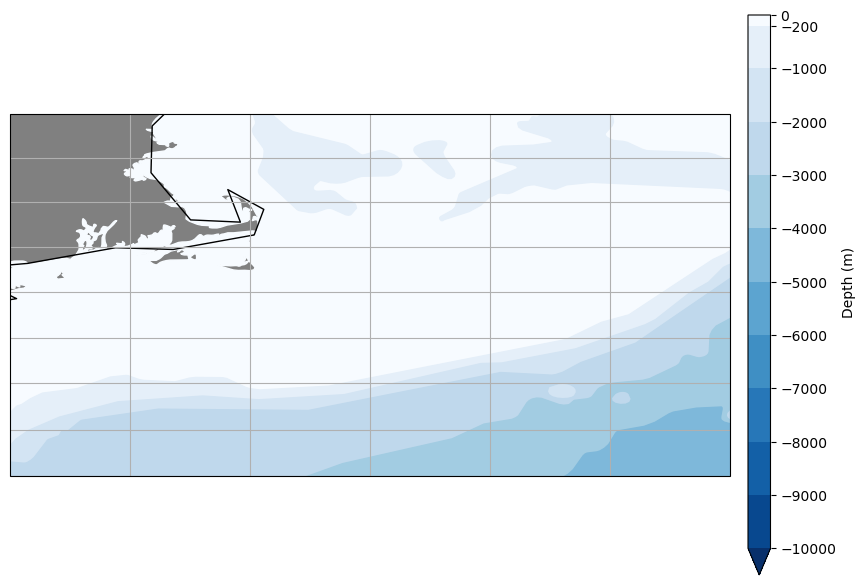

In [34]:
from glob import glob

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader


def load_bathymetry(zip_file_url):
    """Read zip file from Natural Earth containing bathymetry shapefiles"""
    # Download and extract shapefiles
    import io
    import zipfile

    import requests
    r = requests.get(zip_file_url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall("ne_10m_bathymetry_all/")

    # Read shapefiles, sorted by depth
    shp_dict = {}
    files = glob('ne_10m_bathymetry_all/*.shp')
    assert len(files) > 0
    files.sort()
    depths = []
    for f in files:
        depth = '-' + f.split('_')[-1].split('.')[0]  # depth from file name
        depths.append(depth)
        bbox = (-72, 39, -66, 43)  # (x0, y0, x1, y1)
        nei = shpreader.Reader(f, bbox=bbox)
        shp_dict[depth] = nei
    depths = np.array(depths)[::-1]  # sort from surface to bottom
    return depths, shp_dict


if __name__ == "__main__":
    # Load data (14.8 MB file)
    depths_str, shp_dict = load_bathymetry(
        'https://naturalearth.s3.amazonaws.com/' +
        '10m_physical/ne_10m_bathymetry_all.zip')

    # Construct a discrete colormap with colors corresponding to each depth
    depths = depths_str.astype(int)
    N = len(depths)
    nudge = 0.01  # shift bin edge slightly to include data
    boundaries = [min(depths)] + sorted(depths+nudge)  # low to high
    norm = matplotlib.colors.BoundaryNorm(boundaries, N)
    blues_cm = matplotlib.colormaps['Blues_r'].resampled(N)
    colors_depths = blues_cm(norm(depths))

    # Set up plot
    subplot_kw = {'projection': ccrs.LambertCylindrical()}
    fig, ax = plt.subplots(subplot_kw=subplot_kw, figsize=(9, 7))
    ax.set_extent([-72, -66, 39, 43], crs=ccrs.PlateCarree())  # x0, x1, y0, y1

    # Iterate and plot feature for each depth level
    for i, depth_str in enumerate(depths_str):
        ax.add_geometries(shp_dict[depth_str].geometries(),
                          crs=ccrs.PlateCarree(),
                          color=colors_depths[i])

    # Add standard features
    ax.add_feature(cfeature.LAND, color='grey')
    ax.coastlines(lw=1, resolution='110m')
    ax.gridlines(draw_labels=False)
    ax.set_position([0.03, 0.05, 0.8, 0.9])

    # Add custom colorbar
    axi = fig.add_axes([0.85, 0.1, 0.025, 0.8])
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    sm = plt.cm.ScalarMappable(cmap=blues_cm, norm=norm)
    fig.colorbar(mappable=sm,
                 cax=axi,
                 spacing='proportional',
                 extend='min',
                 ticks=depths,
                 label='Depth (m)')

    # Convert vector bathymetries to raster (saves a lot of disk space)
    # while leaving labels as vectors
    ax.set_rasterized(True)

In [36]:
import folium


m = folium.Map(location=[38, -70], zoom_start=4)

video = folium.raster_layers.VideoOverlay(
    video_url="https://www.mapbox.com/bites/00188/patricia_nasa.webm",
    bounds=[[39, -72], [43, -66]],
    opacity=0.65,
    attr="Video from patricia_nasa",
    autoplay=True,
    loop=False,
)

video.add_to(m)

m